In [4]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from tifffile import imread

import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [31]:
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'prediction + input overlay')

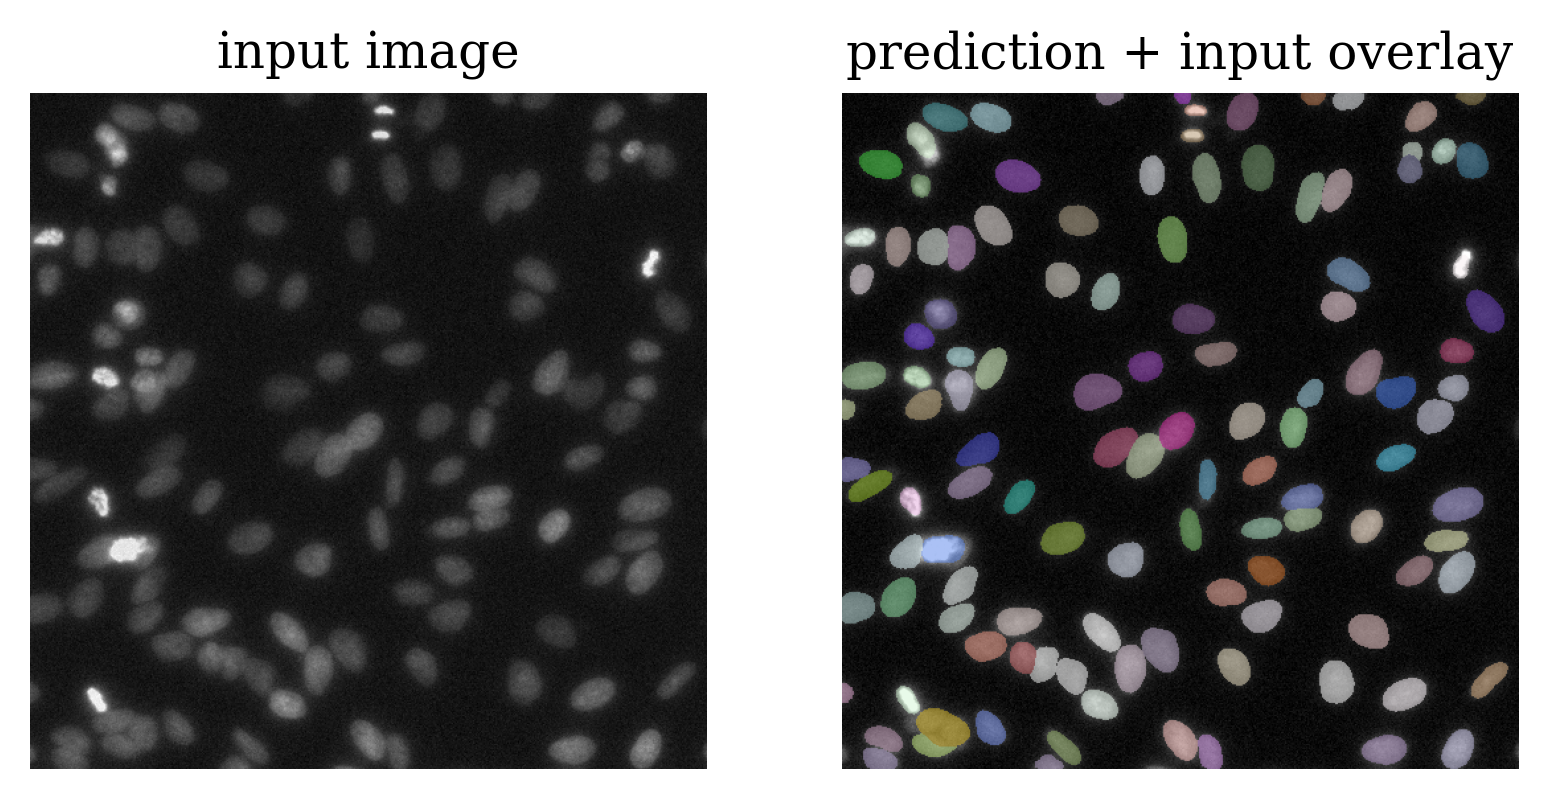

In [28]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

img = test_image_nuclei_2d()

labels, _ = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

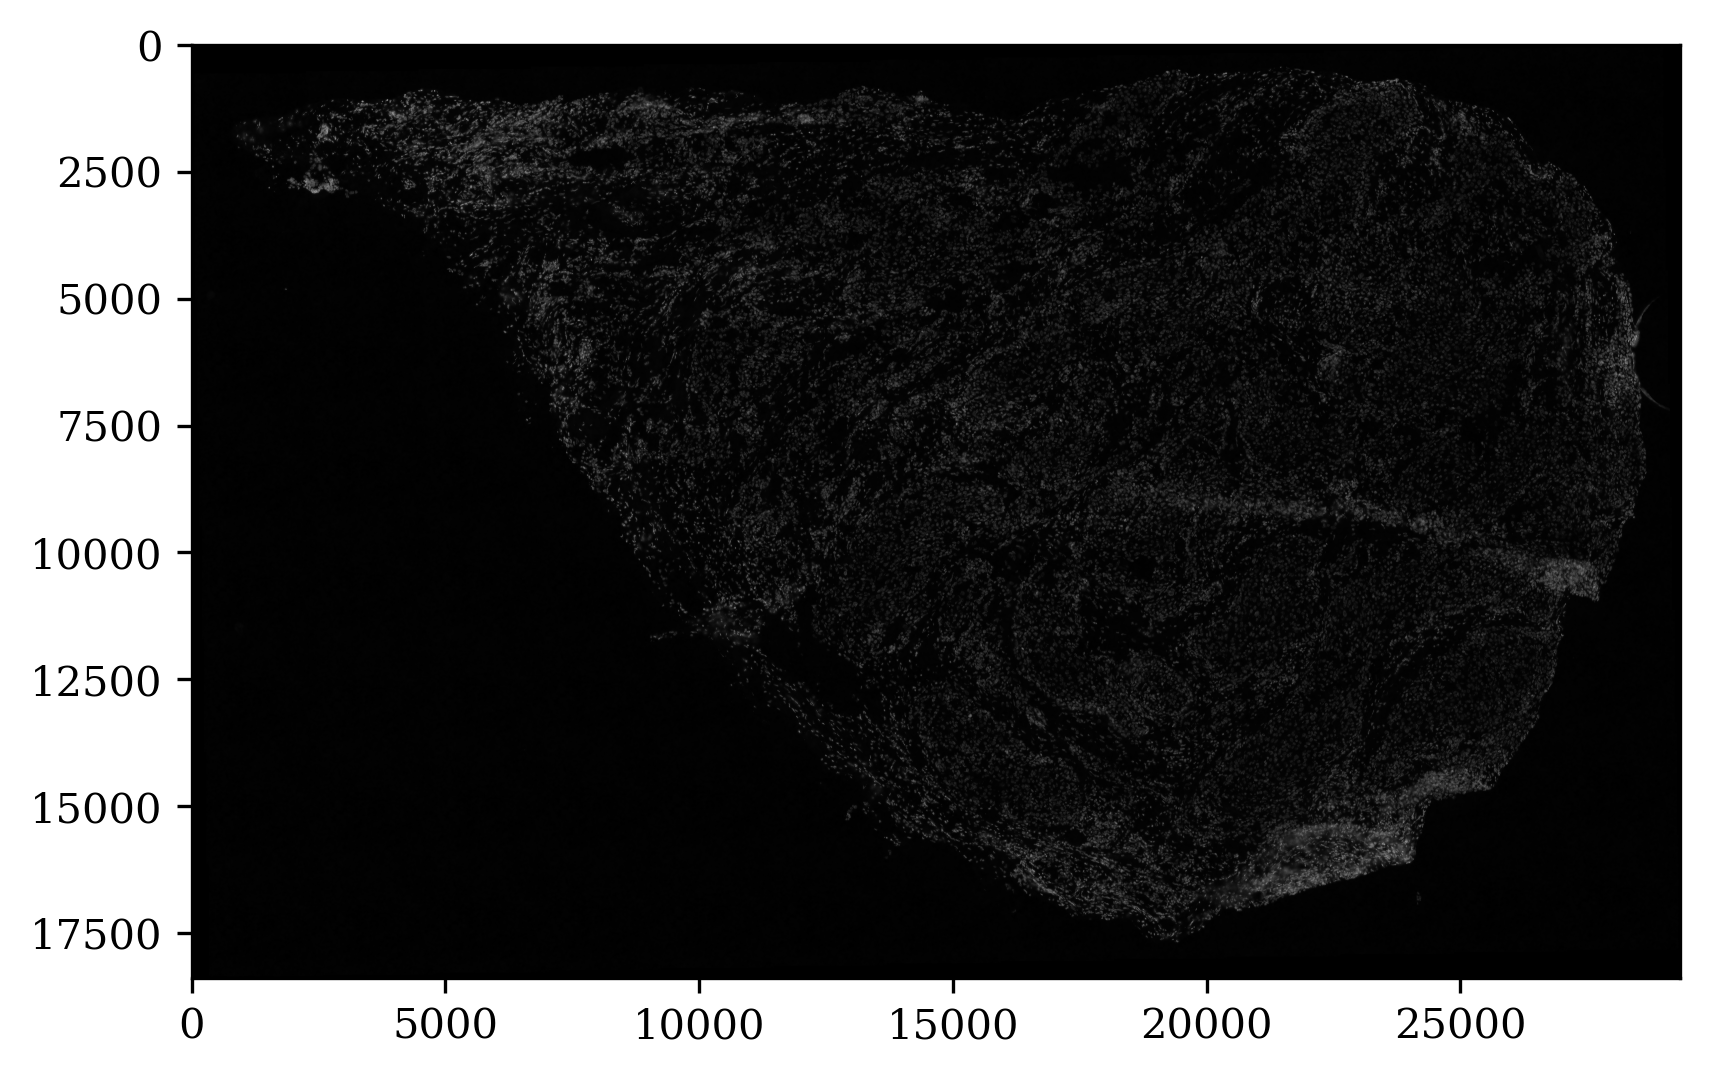

In [34]:
img = imread(r'f:\spatial_data\processed\20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18_processed\stitched\cyc_1_DAPI.tif')
# img = img[3000:4000, 7000:8000]
plt.imshow(img, cmap="gray")

In [68]:
labels, _ = model.predict_instances_big(
            normalize(img),axes='YX',
            block_size=[5000, 5000], min_overlap=[112, 112],
            context=[94, 94],
            labels_out_dtype=np.uint16, show_progress=True, predict_kwargs={'verbose': 0},)

effective: block_size=(5008, 5008), min_overlap=(112, 112), context=(96, 96)


100%|██████████| 28/28 [03:54<00:00,  8.39s/it]


In [76]:
_.keys()

dict_keys(['coord', 'points', 'prob'])

In [73]:
# cut_img = img[7000:9000,13500:15500]
# labels, _ = model.predict_instances(normalize(cut_img))
# trusted = [i+1 for i in range(len(_['prob'])) if _['prob'][i] > 0.5]
# labels = labels * np.isin(labels, trusted)
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

plt.savefig(r'f:\spatial_data\processed\20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18_processed\stitched\cyc_1_DAPI_stardist.png',dpi=2000,bbox_inches='tight')
plt.close()

In [74]:
from tifffile import imwrite
imwrite(r'f:\spatial_data\processed\20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18_processed\stitched\cyc_1_DAPI_stardist.tif', labels)

In [79]:
import numpy as np
from scipy.ndimage import sum

def measure_areas(labels):
    # The index array should start from 1 up to the maximum label because label 0 is usually the background.
    areas = sum(labels > 0, labels, index=np.arange(1, labels.max() + 1))
    return areas

def filter_small_labels(labels, min_size):
    # Measure areas
    areas = measure_areas(labels)
    
    # Filter out small objects: create a mask where each pixel is True if its corresponding label's area is above the threshold
    mask = np.in1d(labels.ravel(), np.where(areas >= min_size)[0] + 1).reshape(labels.shape)
    
    # Apply the mask to the label matrix
    filtered_labels = labels * mask
    return filtered_labels


print(len(np.unique(labels)))

min_size = 400  # Define your size threshold here
filtered_labels = filter_small_labels(labels, min_size)
print(len(np.unique(filtered_labels)))
imwrite(r'f:\spatial_data\processed\20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18_processed\stitched\cyc_1_DAPI_stardist_filtered.tif', filtered_labels)

59381
49687


In [81]:
info_index = np.unique(filtered_labels[filtered_labels>0])-1

In [85]:
info_index

array([    0,     1,     2, ..., 59371, 59375, 59376], dtype=uint16)

In [88]:
_.keys()

dict_keys(['coord', 'points', 'prob'])

In [92]:
centroid = _['points'][info_index]
prob = _['prob'][info_index]

In [90]:
centroid

array([[ 3538,  4786],
       [ 1650,  4298],
       [ 2758,  2242],
       ...,
       [14452, 25572],
       [14040, 25618],
       [14178, 25236]], dtype=int64)

In [93]:
prob

array([0.96007365, 0.9507033 , 0.94703984, ..., 0.5193324 , 0.50734854,
       0.4916499 ], dtype=float32)

In [95]:
df = pd.DataFrame(centroid, columns=['Y','X'], index=info_index)
df['prob'] = prob
df

,Y,X,prob
0,3538,4786,0.960074
1,1650,4298,0.950703
2,2758,2242,0.947040
3,2308,2040,0.944545
4,2138,2780,0.944068
...,...,...,...
59368,14676,25230,0.534003
59369,14090,25272,0.531222
59371,14452,25572,0.519332
59375,14040,25618,0.507349


## pipeline

In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.ndimage import sum
from tifffile import imread
from tifffile import imwrite

from stardist.models import StarDist2D
from csbdeep.utils import normalize


BLOCK_SIZE = [5000, 5000]
MIN_OVERLAP = [448, 448]
CONTEXT = [94, 94]
MIN_CELL_SIZE = 400
BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20240805_TCR_PRISM30_TNBC_BZ02_CA2_immune_no16,17,18'


def segment2D_stardist(img):
    # creates a pretrained model
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    labels, info = model.predict_instances_big(normalize(img), axes='YX',
                block_size=BLOCK_SIZE, min_overlap=MIN_OVERLAP, context=CONTEXT,
                labels_out_dtype=np.uint16, show_progress=True, predict_kwargs={'verbose': 0},)    

    def measure_areas(labels):
        # The index array should start from 1 up to the maximum label because label 0 is usually the background.
        areas = sum(labels > 0, labels, index=np.arange(1, labels.max() + 1))
        return areas
    
    def filter_small_labels(labels, min_size):
        # Measure areas
        areas = measure_areas(labels)
        mask = np.in1d(labels.ravel(), np.where(areas >= min_size)[0] + 1).reshape(labels.shape)
        filtered_labels = labels * mask
        return filtered_labels

    filtered_labels = filter_small_labels(labels, MIN_CELL_SIZE)
    info_index = np.unique(filtered_labels[filtered_labels>0])-1
    centroid = info['points'][info_index]
    prob = info['points'][info_index]
    dapi_predict = pd.DataFrame(centroid, columns=['Y','X'], index=info_index)
    dapi_predict['prob'] = prob
    return labels, dapi_predict


def segment_pipeline(run_id):
    base_dir = BASE_DIR / f'{run_id}_processed'
    stc_dir = base_dir / 'stitched'
    seg_dir = base_dir / 'segmented'
    os.makedirs(seg_dir, exist_ok=True)

    cell_im_name = 'cyc_1_DAPI'
    img = imread(stc_dir/f'{cell_im_name}.tif')
    labels, dapi_predict = segment2D_stardist(img)
    
    imwrite(seg_dir/f'{cell_im_name}_stardist.tif', labels)
    dapi_predict.to_csv(seg_dir / 'dapi_predict.csv', index=True)
    dapi_predict[['Y','X']].to_csv(seg_dir / 'dapi_centroids.csv', index=True)


# if __name__ == '__main__':
#     seg_dir = BASE_DIR / f'{RUN_ID}_processed' / 'segmented'
#     seg_dir.mkdir(exist_ok=True)
    
#     # copy this file to the dest_dir
#     current_file_path = os.path.abspath(__file__)
#     target_file_path = os.path.join(seg_dir, os.path.basename(current_file_path))
#     try: shutil.copy(current_file_path, target_file_path)
#     except shutil.SameFileError: print('The file already exists in the destination directory.')
#     except PermissionError: print("Permission denied: Unable to copy the file.")
#     except FileNotFoundError: print("File not found: Source file does not exist.")
#     except Exception as e: print(f"An error occurred: {e}")
    
#     segment_pipeline(RUN_ID)

In [3]:
run_id = RUN_ID
base_dir = BASE_DIR / f'{run_id}_processed'
stc_dir = base_dir / 'stitched'
seg_dir = base_dir / 'segmented'
os.makedirs(seg_dir, exist_ok=True)

cell_im_name = 'cyc_1_DAPI'
img = imread(stc_dir/f'{cell_im_name}.tif')

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')
labels, info = model.predict_instances_big(normalize(img), axes='YX',
            block_size=BLOCK_SIZE, min_overlap=MIN_OVERLAP, context=CONTEXT,
            labels_out_dtype=np.uint16, show_progress=True, predict_kwargs={'verbose': 0},)    

def measure_areas(labels):
    # The index array should start from 1 up to the maximum label because label 0 is usually the background.
    areas = sum(labels > 0, labels, index=np.arange(1, labels.max() + 1))
    return areas

def filter_small_labels(labels, min_size):
    # Measure areas
    areas = measure_areas(labels)
    mask = np.in1d(labels.ravel(), np.where(areas >= min_size)[0] + 1).reshape(labels.shape)
    filtered_labels = labels * mask
    return filtered_labels

filtered_labels = filter_small_labels(labels, MIN_CELL_SIZE)
info_index = np.unique(filtered_labels[filtered_labels>0])-1

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(5008, 5008), min_overlap=(448, 448), context=(96, 96)


100%|██████████| 35/35 [04:20<00:00,  7.44s/it]


In [7]:
centroid = info['points'][info_index]
prob = info['prob'][info_index]

In [8]:
prob

array([0.96005374, 0.9506981 , 0.94698715, ..., 0.48272285, 0.48192006,
       0.4803285 ], dtype=float32)

In [9]:
dapi_predict = pd.DataFrame(centroid, columns=['Y','X'], index=info_index)
dapi_predict['prob'] = prob

In [11]:
dapi_predict.to_csv(seg_dir / 'dapi_predict.csv', index=True)
dapi_predict[['Y','X']].to_csv(seg_dir / 'dapi_centroids.csv', index=True)
imwrite(seg_dir/f'{cell_im_name}_stardist.tif', labels)